**CS7357 – Neural Networks and Deep Learning**  
**Assignment 4:** Apple Stock Price Prediction using Recurrent Neural Network (RNN)  
**Name:** Sukumar Muthusamy  
**Section:** W01  
**Term:** Fall 2025  
**Submission Date:** 10/31/2025

## Task 1: Download historical stock price data of Apple

In this step, I download the historical stock price data of Apple (AAPL) using the yfinance library. The dataset contains columns such as Date, Open, High, Low, Close, and Volume, representing the daily trading information for Apple’s stock. I focus on the ‘Close’ price, as it reflects the final market value for each trading day and serves as the main feature for training the RNN model.

To verify that the dataset is downloaded correctly, I parse the Date column to datetime format, sort the entries in chronological order, and inspect the shape, date range, and a few initial rows. I also check for missing or duplicate values to ensure the dataset is clean and consistent before proceeding to visualization in Task 2.

In [ ]:
import pandas as pd

# To import yfinance (and install if missing)
try:
    import yfinance as yf
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip -q install yfinance --upgrade
    import yfinance as yf

# To configure ticker and date range
TICKER = "AAPL"
START  = "2015-01-01"
END    = None   # None -> up to current date

# To download daily OHLCV data for Apple (AAPL)
raw = yf.download(TICKER, start=START, end=END, auto_adjust=False, progress=False, group_by="column")

# To handle possible MultiIndex columns (e.g., ('AAPL','Open') -> 'Open')
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# To prepare a clean DataFrame with standard columns
df = (
    raw.reset_index()
       .rename(columns={"Date": "date"})
       .loc[:, ["date", "Open", "High", "Low", "Close", "Volume"]]
       .copy()
)

# To enforce dtypes and chronological order
df["date"] = pd.to_datetime(df["date"])
for c in ["Open", "High", "Low", "Close"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce").astype("Int64")
df = df.sort_values("date").drop_duplicates(subset="date", keep="first").reset_index(drop=True)

# =================== Basic Info ===================
print("\n" + "="*80)
print("\033[1mDataset downloaded (AAPL): Shape and Basic Info\033[0m")
print("="*80)
print(f"Rows: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['date'].min().date()} -> {df['date'].max().date()}")

# =================== Sanity Checks ===================
print("\n" + "="*80)
print("\033[1mSanity checks (structure, NAs, duplicates)\033[0m")
print("="*80)
print("Dtypes:")
print(df.dtypes.to_string())
print("\nMissing values by column:")
print(df.isna().sum().to_string())
dup_cnt = df["date"].duplicated().sum()
print(f"\nDuplicate dates: {dup_cnt}")

# =================== Preview ===================
print("\n" + "="*80)
print("\033[1mPreview (first 5 rows)\033[0m")
print("="*80)
print(df.head().to_string(index=False))

print("\n" + "="*80)
print("\033[1mPreview (last 5 rows)\033[0m")
print("="*80)
print(df.tail().to_string(index=False))

# To keep a copy for later tasks
AAPL_df = df.copy()


Dataset downloaded (AAPL): Shape and Basic Info
Rows: 2,725
Columns: ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
Date range: 2015-01-02 -> 2025-10-31

Sanity checks (structure, NAs, duplicates)
Dtypes:
Price
date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             Int64

Missing values by column:
Price
date      0
Open      0
High      0
Low       0
Close     0
Volume    0

Duplicate dates: 0

Preview (first 5 rows)
      date      Open      High       Low     Close    Volume
2015-01-02 27.847500 27.860001 26.837500 27.332500 212818400
2015-01-05 27.072500 27.162500 26.352501 26.562500 257142000
2015-01-06 26.635000 26.857500 26.157499 26.565001 263188400
2015-01-07 26.799999 27.049999 26.674999 26.937500 160423600
2015-01-08 27.307501 28.037500 27.174999 27.972500 237458000

Preview (last 5 rows)
      date       Open       High        Low      Close   Volume
2025-10-27 264.880005 269.119995

## Task 2: Plot the ‘Close’ price with respect to time

In this step, I visualize the Apple (AAPL) Close price as a time-series line plot to observe overall trends, seasonal behavior, and volatility over the selected date range. I use the cleaned DataFrame from Task 1, ensuring the date column is in chronological order and the Close values are valid (non-missing and numeric).

For clarity, I label the axes (Date on the x-axis and Close Price (USD) on the y-axis), include a concise title, and format the date ticks for readability. This plot serves as a baseline view of the series before sequence construction and modeling, helping identify long-term growth, drawdowns, and abrupt regime changes that the RNN must learn to handle in later tasks.

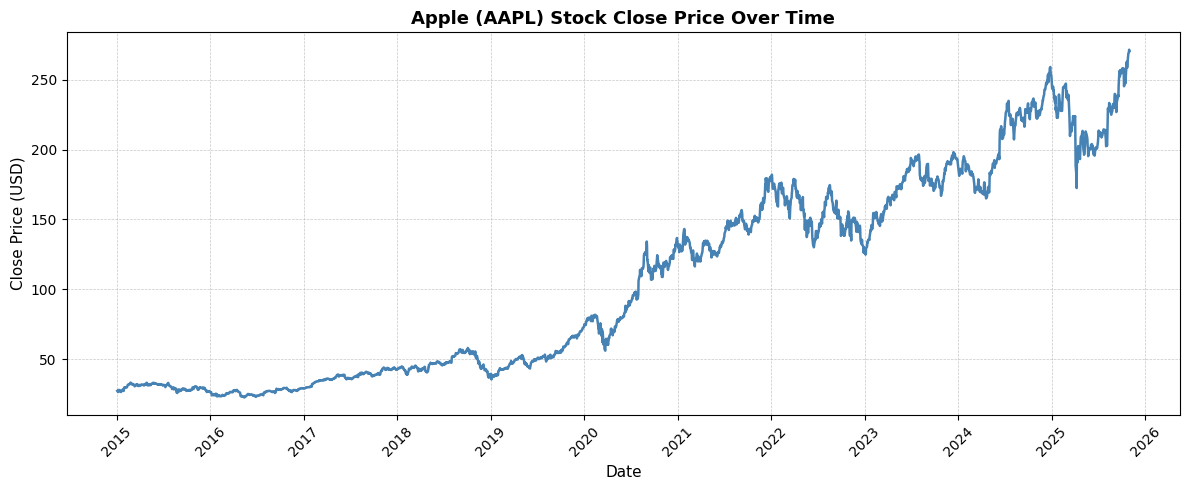

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# To verify that Close prices are valid and sorted before plotting
assert "date" in AAPL_df.columns and "Close" in AAPL_df.columns, "Required columns missing."
AAPL_df = AAPL_df.sort_values("date").dropna(subset=["Close"])

# =================== Plotting ===================
plt.figure(figsize=(12, 5))
plt.plot(AAPL_df["date"], AAPL_df["Close"], color='steelblue', linewidth=1.8)

# To format the plot for readability
plt.title("Apple (AAPL) Stock Close Price Over Time", fontsize=13, fontweight='bold')
plt.xlabel("Date", fontsize=11)
plt.ylabel("Close Price (USD)", fontsize=11)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# To format date ticks (every year, rotated for clarity)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Task 3: Define the RNN design and fit the model

In this step, I design and train a Recurrent Neural Network (RNN) model to predict future Apple (AAPL) stock prices based on the historical ‘Close’ values obtained in the previous tasks. Since stock prices form a sequential time-series, I convert the data into input–output pairs where each input sequence represents a fixed number of past days, and the output corresponds to the next day’s closing price.

Before training, I normalize the Close prices to a range between 0 and 1 using MinMaxScaler to ensure faster convergence and stable gradients during backpropagation. The dataset is then divided into training and testing sets, maintaining chronological order to preserve temporal dependencies.

The model is implemented using TensorFlow Keras, consisting of a SimpleRNN layer followed by a Dense output layer. The RNN layer captures sequential relationships and learns temporal dependencies between previous price movements, while the Dense layer produces a single predicted value for the next closing price. The model is compiled using Mean Squared Error (MSE) as the loss function and the Adam optimizer for efficient gradient updates.

During training, I monitor the loss across epochs to ensure that the model converges properly and avoids overfitting. Once training is complete, the trained model is evaluated on the test data to measure its ability to generalize to unseen time periods.

In [ ]:
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# To fix randomness for training-related steps
RANDOM_SEED = 13
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# To prepare the univariate Close-price series
assert "date" in AAPL_df.columns and "Close" in AAPL_df.columns, "Required columns missing."
series_df = AAPL_df.loc[:, ["date", "Close"]].dropna().sort_values("date").reset_index(drop=True)

# To scale Close to [0, 1] for stable training
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(series_df[["Close"]].values)  # shape (N, 1)

# To create supervised sequences (X: past window, y: next step)
def make_sequences(values, window):
    X, y = [], []
    for i in range(window, len(values)):
        X.append(values[i - window:i, 0])
        y.append(values[i, 0])
    X = np.array(X)                           # (samples, window)
    y = np.array(y)                           # (samples,)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, window, 1)
    return X, y

WINDOW = 60
X_all, y_all = make_sequences(close_scaled, WINDOW)

# To split chronologically into train/val/test (no shuffling)
train_ratio = 0.80
val_ratio   = 0.10  # of the full dataset (kept chronological)
n_total = X_all.shape[0]
n_train = int(n_total * train_ratio)
n_val   = int(n_total * val_ratio)
n_test  = n_total - n_train - n_val

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_val,   y_val   = X_all[n_train:n_train + n_val], y_all[n_train:n_train + n_val]
X_test,  y_test  = X_all[n_train + n_val:],        y_all[n_train + n_val:]

# =================== Dataset Summary ===================
print("\n" + "="*80)
print("\033[1mRNN Dataset (Sequences) — Shapes\033[0m")
print("="*80)
print(f"WINDOW: {WINDOW} timesteps")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}   | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

# To define a simple RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(WINDOW, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# =================== Model Summary ===================
print("\n" + "="*80)
print("\033[1mRNN Model Summary\033[0m")
print("="*80)
model.summary(print_fn=lambda line: print(line))

# To fit the model (chronological, no shuffling)
EPOCHS = 25
BATCH  = 32
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, y_val),
    shuffle=False,
    verbose=1
)

# =================== Training Log ===================
print("\n" + "="*80)
print("\033[1mTraining Completed — Final Losses\033[0m")
print("="*80)
final_train_loss = history.history["loss"][-1]
final_val_loss   = history.history["val_loss"][-1] if "val_loss" in history.history else np.nan
print(f"Train MSE: {final_train_loss:.6f}")
print(f"Val   MSE: {final_val_loss:.6f}")

# To keep the artifacts for the next tasks
RNN_WINDOW   = WINDOW
RNN_SCALER   = scaler
RNN_MODEL    = model
RNN_HISTORY  = history
RNN_DATASETS = {
    "X_train": X_train, "y_train": y_train,
    "X_val":   X_val,   "y_val":   y_val,
    "X_test":  X_test,  "y_test":  y_test
}


RNN Dataset (Sequences) — Shapes
WINDOW: 60 timesteps
X_train: (2132, 60, 1) | y_train: (2132,)
X_val:   (266, 60, 1)   | y_val:   (266,)
X_test:  (267, 60, 1)  | y_test:  (267,)

RNN Model Summary


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 4,289 (16.75 KB)
 Trainable params: 4,289 (16.75 KB)
 Non-trainable params: 0 (0.00 B)

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.7230e-04 - val_loss: 8.0573e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9424e-04 - val_loss: 4.3476e-04
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7610e-04 - val_loss: 7.1523e-04
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3

## Task 4: Analyze the model

In this step, I evaluate the trained Recurrent Neural Network (RNN) model to measure its performance in predicting the future closing price of Apple (AAPL). The evaluation focuses on three key regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and the Coefficient of Determination (R²).

The **MAE** measures the average magnitude of prediction errors without considering their direction, representing how far predictions deviate from actual prices on average. The **MSE** penalizes larger errors more heavily, providing insight into how consistent the predictions are. The **R² score** indicates the proportion of variance in the actual stock prices that is explained by the model. Higher values closer to 1 suggest a stronger predictive relationship.

To compute these metrics, I use the model’s predictions on the test set and inverse-transform them back to their original scale using the MinMaxScaler applied earlier. This ensures that the evaluation is performed in real price units (USD). The results help determine whether the model captures the general price movements effectively or if additional tuning or architectural improvements are required in later tasks.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# To verify required artifacts from Task 3
assert "RNN_MODEL"   in globals(), "Model not found."
assert "RNN_SCALER"  in globals(), "Scaler not found."
assert "RNN_WINDOW"  in globals(), "Window size not found."
assert "RNN_DATASETS" in globals(), "Datasets not found."

model   = RNN_MODEL
scaler  = RNN_SCALER
WINDOW  = RNN_WINDOW
X_test  = RNN_DATASETS["X_test"]
y_test  = RNN_DATASETS["y_test"]

# To predict on the test set
y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1, 1)
y_true_scaled = y_test.reshape(-1, 1)

# To inverse-transform predictions and targets to original USD scale
y_pred = scaler.inverse_transform(y_pred_scaled).ravel()
y_true = scaler.inverse_transform(y_true_scaled).ravel()

# To compute regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

# =================== Metrics ===================
print("\n" + "="*80)
print("\033[1mRNN Evaluation on Test Set\033[0m")
print("="*80)
print(f"Samples: {len(y_true):,}")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"R^2: {r2:.6f}")

# To attach dates for the test targets (for reference in Task 5)
# series_df was built in Task 3 from AAPL_df[['date','Close']] sorted ascending
assert "series_df" in globals(), "series_df not found."
n_total = len(series_df)
n_seq   = n_total - WINDOW               # total supervised samples created
n_train = len(RNN_DATASETS["X_train"])
n_val   = len(RNN_DATASETS["X_val"])
start_idx = WINDOW + n_train + n_val
test_dates = series_df["date"].iloc[start_idx : start_idx + len(y_true)].reset_index(drop=True)

# To preview a few rows for sanity
import pandas as pd
preview = pd.DataFrame({
    "date":  test_dates,
    "actual_close":  y_true,
    "pred_close":    y_pred
})
print("\n" + "="*80)
print("\033[1mPreview: actual vs predicted (first 10)\033[0m")
print("="*80)
print(preview.head(10).to_string(index=False))

# To keep the artifacts for Task 5
RNN_RESULTS = {
    "dates_test": test_dates,
    "y_true":     y_true,
    "y_pred":     y_pred,
    "mae":        mae,
    "mse":        mse,
    "r2":         r2
}


RNN Evaluation on Test Set
Samples: 267
MAE: 3.678666
MSE: 24.522241
R^2: 0.935305

Preview: actual vs predicted (first 10)
      date  actual_close  pred_close
2024-10-09    229.539993  224.570511
2024-10-10    229.039993  226.664963
2024-10-11    227.550003  228.518646
2024-10-14    231.300003  226.276993
2024-10-15    233.850006  230.397842
2024-10-16    231.779999  231.796509
2024-10-17    232.149994  231.198395
2024-10-18    235.000000  230.206863
2024-10-21    236.479996  232.972061
2024-10-22    235.860001  234.397720


## Task 5: Visualization of predicted vs actual close prices

In this step, I visualize the predicted closing prices against the actual closing prices for the test period to assess how well the RNN model tracks real market movements. I use the dates aligned from the original series so that both curves are plotted on the same time axis.

For clarity, I produce a single time-series chart with two lines. One line shows the actual close price in USD and the other shows the model’s predicted close price. I label the axes, include a concise title, and format the date ticks for readability. This visual comparison helps identify periods where the model follows the trend closely and periods where it lags or overshoots, which informs whether further tuning or architectural changes are needed.

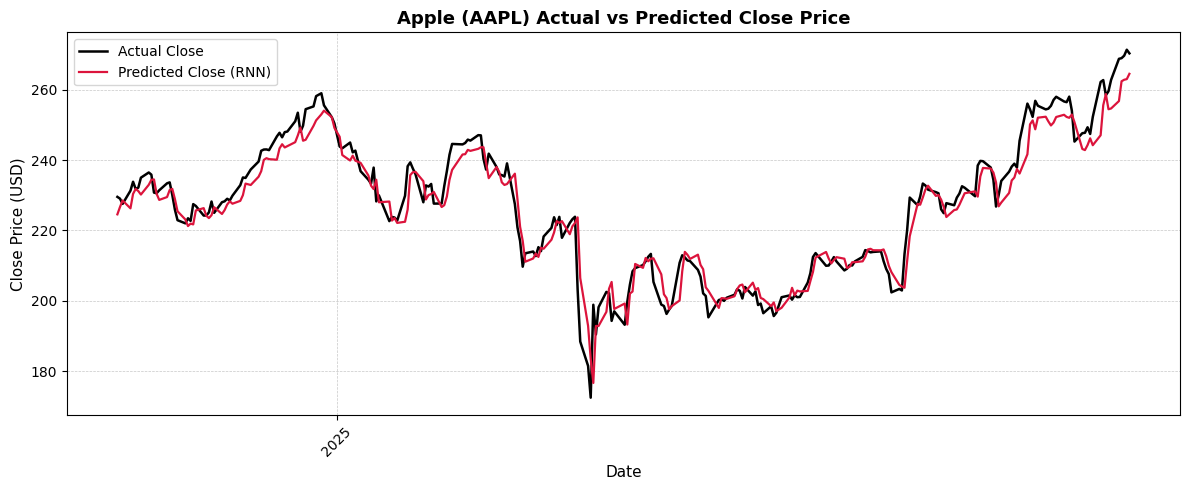


RNN Model Performance Summary
MAE: 3.678666
MSE: 24.522241
R^2: 0.935305


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# To verify that evaluation results from Task 4 exist
assert "RNN_RESULTS" in globals(), "RNN_RESULTS not found."

dates_test = RNN_RESULTS["dates_test"]
y_true     = RNN_RESULTS["y_true"]
y_pred     = RNN_RESULTS["y_pred"]

# =================== Plotting ===================
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_true, label="Actual Close", color="black", linewidth=1.8)
plt.plot(dates_test, y_pred, label="Predicted Close (RNN)", color="crimson", linewidth=1.6)

plt.title("Apple (AAPL) Actual vs Predicted Close Price", fontsize=13, fontweight='bold')
plt.xlabel("Date", fontsize=11)
plt.ylabel("Close Price (USD)", fontsize=11)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# To format date ticks (every year, rotated for clarity)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# To print metrics summary again for convenience
print("\n" + "="*80)
print("\033[1mRNN Model Performance Summary\033[0m")
print("="*80)
print(f"MAE: {RNN_RESULTS['mae']:.6f}")
print(f"MSE: {RNN_RESULTS['mse']:.6f}")
print(f"R^2: {RNN_RESULTS['r2']:.6f}")